In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
import re
import codecs

In [85]:
wellcome = pd.read_csv('C:\\Users\\kenne\\Desktop\\WELLCOME_APCspend2013_forThinkful.csv', encoding='latin-1')

print(wellcome.head())

              PMID/PMCID Publisher           Journal title  \
0                    NaN       CUP  Psychological Medicine   
1             PMC3679557       ACS       Biomacromolecules   
2  23043264  PMC3506128        ACS              J Med Chem   
3    23438330 PMC3646402       ACS              J Med Chem   
4   23438216 PMC3601604        ACS              J Org Chem   

                                       Article title  \
0  Reduced parahippocampal cortical thickness in ...   
1  Structural characterization of a Model Gram-ne...   
2  Fumaroylamino-4,5-epoxymorphinans and related ...   
3  Orvinols with mixed kappa/mu opioid receptor a...   
4  Regioselective opening of myo-inositol orthoes...   

  COST (£) charged to Wellcome (inc VAT when charged)  
0                                              £0.00   
1                                           £2381.04   
2                                            £642.56   
3                                            £669.64   
4         


Determine the five most common journals and the total articles for each.

Next, calculate the mean, median, and standard deviation of the open-access cost per article for each journal. 


In [86]:
wellcome.describe(include='all')

,PMID/PMCID,Publisher,Journal title,Article title,COST (£) charged to Wellcome (inc VAT when charged)
count,1928,2127,2126,2127,2127
unique,1880,299,984,2126,1402
top,-,Elsevier,PLoS One,"Exclusive breastfeeding, diarrhoel morbidity a...",£2040.00
freq,7,387,92,2,94


In [87]:
# Values in the COST (£) charged to Wellcome (inc VAT when charged) column are listed as a string. We will need to convert to numbers.
# In the explanation of the data document it states all costs have been converted into £ sterling. We will assume the $ should be £.
# We'll place the converted costs into a new column titled 'Cost' and remove the original column.

wellcome['Cost'] = wellcome['COST (£) charged to Wellcome (inc VAT when charged)'].str.strip('£').str.strip('$')

del wellcome['COST (£) charged to Wellcome (inc VAT when charged)']

wellcome['Cost'] = pd.to_numeric(wellcome.Cost)

In [88]:
print(wellcome.head())

              PMID/PMCID Publisher           Journal title  \
0                    NaN       CUP  Psychological Medicine   
1             PMC3679557       ACS       Biomacromolecules   
2  23043264  PMC3506128        ACS              J Med Chem   
3    23438330 PMC3646402       ACS              J Med Chem   
4   23438216 PMC3601604        ACS              J Org Chem   

                                       Article title     Cost  
0  Reduced parahippocampal cortical thickness in ...     0.00  
1  Structural characterization of a Model Gram-ne...  2381.04  
2  Fumaroylamino-4,5-epoxymorphinans and related ...   642.56  
3  Orvinols with mixed kappa/mu opioid receptor a...   669.64  
4  Regioselective opening of myo-inositol orthoes...   685.88  


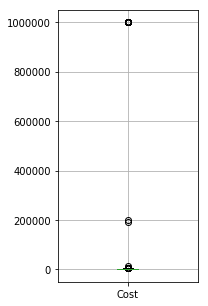

In [89]:
# Using simple boxplot to see if we have any outliers in our new Cost column.
plt.figure(figsize=(2.5, 5))

wellcome.boxplot(column=['Cost'])

plt.show()

In [100]:
# Use this code to check initial outliers and confirm clean-up.

cost_outliers = wellcome.loc[lambda df: wellcome['Cost'] > 10000]

print(cost_outliers)

Empty DataFrame
Columns: [PMID/PMCID, Publisher, Journal title, Article title, Cost]
Index: []


In [91]:
# We're going to remove the most extreme values (999999.0) in the cost field as they appear to be pure data entry errors and
# we can't easily determine what the correct value should be.
wellcome.drop(wellcome[(wellcome.Cost > 900000.0)].index, inplace=True)

In [103]:
# Now we're left with three outliers (13200.00, 192645.0, 201024.0) that we can convert by correcting the decimal point placement.
wellcome.loc[wellcome['PMID/PMCID'] == '3547931', 'Cost'] = 1926.45
wellcome.loc[wellcome['PMID/PMCID'] == 'PMC3664409\n\n', 'Cost'] = 2010.24
wellcome.loc[wellcome['Article title'] == 'Fungal Disease in Britain and the United States 1850-2000', 'Cost'] = 1320.00

In [104]:
# The new Cost column is all cleaned up!
wellcome.describe()

,Cost
count,2080.000000
mean,1821.955197
std,767.237986
min,0.000000
25%,1268.700000
50%,1851.650000
75%,2300.817500
max,6000.000000


In [105]:
# Now we're going to look at the Journal tile column:

# In the event capitalization is inconsistent in the Journal title column, we can cast each string to lower case.
wellcome['Journal title'] = wellcome['Journal title'].str.lower()

# For example, ACS NANO and ACS Nano are both acs nano and will be group accordingly.

In [106]:
# We can also strip any whitespace in the Journal title column.
wellcome['Journal title'] = wellcome['Journal title'].str.strip()

In [109]:
# We can remove any special characters such as : , - _ . / ( ) ; that may be used inconsistently.
wellcome['Journal title'] = wellcome['Journal title'].str.replace(':', '')
wellcome['Journal title'] = wellcome['Journal title'].str.replace(',', '')
wellcome['Journal title'] = wellcome['Journal title'].str.replace('-', '')
wellcome['Journal title'] = wellcome['Journal title'].str.replace('_', '')
wellcome['Journal title'] = wellcome['Journal title'].str.replace('.', '')
wellcome['Journal title'] = wellcome['Journal title'].str.replace('/', '')
wellcome['Journal title'] = wellcome['Journal title'].str.replace('(', '')
wellcome['Journal title'] = wellcome['Journal title'].str.replace(')', '')
wellcome['Journal title'] = wellcome['Journal title'].str.replace(';', '')

# For example, BMC Geomics. and BMC Genomics are both bmc genomics.

In [110]:
# We can also create consistency between 'and' and '&'.
wellcome['Journal title'] = wellcome['Journal title'].str.replace('&;', 'and')

# For example, Antioxidants & Redox Signaling has been changed to antioxidants and redox signaling like the others.

In [124]:
# You now have a Journal title column where the differences should be limited to how the alphanumeric values were entered.
# From here you can search for those deltas and clean them up using similar string methods.
# Since that process will take a considerable amount of time we're going to finsih with our top 5 summary.
print('The five most common journals by article count are:')
top_five = wellcome['Journal title'].value_counts()[:5]
print(top_five)

The five most common journals by article count are:
plos one                           183
journal of biological chemistry     52
neuroimage                          29
nucleic acids research              26
plos genetics                       22
Name: Journal title, dtype: int64


In [147]:
plos_one_mean = wellcome.loc[lambda df: wellcome['Journal title'] == 'plos one', 'Cost'].mean()
plos_one_median = wellcome.loc[lambda df: wellcome['Journal title'] == 'plos one', 'Cost'].median()
plos_one_sd = wellcome.loc[lambda df: wellcome['Journal title'] == 'plos one', 'Cost'].std(ddof=1)

jobc_mean = wellcome.loc[lambda df: wellcome['Journal title'] == 'journal of biological chemistry', 'Cost'].mean()
jobc_median = wellcome.loc[lambda df: wellcome['Journal title'] == 'journal of biological chemistry', 'Cost'].median()
jobc_sd = wellcome.loc[lambda df: wellcome['Journal title'] == 'journal of biological chemistry', 'Cost'].std(ddof=1)

neuro_mean = wellcome.loc[lambda df: wellcome['Journal title'] == 'neuroimage', 'Cost'].mean()
neuro_median = wellcome.loc[lambda df: wellcome['Journal title'] == 'neuroimage', 'Cost'].median()
neuro_sd = wellcome.loc[lambda df: wellcome['Journal title'] == 'neuroimage', 'Cost'].std(ddof=1)

nar_mean = wellcome.loc[lambda df: wellcome['Journal title'] == 'nucleic acids research', 'Cost'].mean()
nar_median = wellcome.loc[lambda df: wellcome['Journal title'] == 'nucleic acids research', 'Cost'].median()
nar_sd = wellcome.loc[lambda df: wellcome['Journal title'] == 'nucleic acids research', 'Cost'].std(ddof=1)

plos_gen_mean = wellcome.loc[lambda df: wellcome['Journal title'] == 'plos genetics', 'Cost'].mean()
plos_gen_median = wellcome.loc[lambda df: wellcome['Journal title'] == 'plos genetics', 'Cost'].median()
plos_gen_sd = wellcome.loc[lambda df: wellcome['Journal title'] == 'plos genetics', 'Cost'].std(ddof=1)

In [154]:
print('The mean, median and standard deviation for Plos One equals ${}, ${} and ${}.'.format(
    round(plos_one_mean, 2), round(plos_one_median, 2), round(plos_one_sd, 2)))
print('')
print('The mean, median and standard deviation for the Journal of Biological Chemistry equals ${}, ${} and ${}.'.format(
    round(jobc_mean, 2), round(jobc_median, 2), round(jobc_sd, 2)))
print('')
print('The mean, median and standard deviation for Neuroimage equals ${}, ${} and ${}.'.format(
    round(neuro_mean, 2), round(neuro_median, 2), round(neuro_sd, 2)))
print('')
print('The mean, median and standard deviation for Nucleic Acids Research equals ${}, ${} and ${}.'.format(
    round(nar_mean, 2), round(nar_median, 2), round(nar_sd, 2)))
print('')
print('The mean, median and standard deviation for Plos Genetics equals ${}, ${} and ${}.'.format(
    round(plos_gen_mean, 2), round(plos_gen_median, 2), round(plos_gen_sd, 2)))

The mean, median and standard deviation for Plos One equals $940.08, $896.99 and $214.23.

The mean, median and standard deviation for the Journal of Biological Chemistry equals $1423.59, $1301.14 and $411.95.

The mean, median and standard deviation for Neuroimage equals $2215.17, $2326.43 and $266.65.

The mean, median and standard deviation for Nucleic Acids Research equals $1149.0, $852.0 and $442.94.

The mean, median and standard deviation for Plos Genetics equals $1643.11, $1712.73 and $153.37.
